##### Copyright 2019 The TensorFlow Authors. [Licensed under the Apache License, Version 2.0](#scrollTo=y_UVSRtBBsJk).

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
// Licensed under the Apache License, Version 2.0 (the "License");
// you may not use this file except in compliance with the License.
// You may obtain a copy of the License at
//
// https://www.apache.org/licenses/LICENSE-2.0
//
// Unless required by applicable law or agreed to in writing, software
// distributed under the License is distributed on an "AS IS" BASIS,
// WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
// See the License for the specific language governing permissions and
// limitations under the License.

# Dogs vs Cats Image Classification Without Image Augmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/13lBsht3Wa4GjKKkA47JCrd54XikhNX2E"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="Link to be updated"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />GitHub link to be updated accordingly</a>
  </td>
</table>



In this tutorial, we will discuss how to classify images into pictures of cats or pictures of dogs. We'll build an image classifier using `Layer` and load data by creating Training and Validation Tensors of Images as well as their corresponding Labels

## Specific concepts that will be covered:
In the process, we will build practical experience and develop intuition around the following concepts

* Building _data input pipelines_  — How can we efficiently work with data on disk to interface with our model? 
* _Overfitting_ - what is it, how to identify it? . 

<hr>


**Before you begin**

Before running the code in this notebook, reset the runtime by going to **Runtime -> Reset all runtimes** in the menu above. If you have been working through several notebooks, this will help you avoid reaching Colab's memory limits.


# Importing packages

Let's start by importing required packages:

*   glob — to read files and directory structure
*   numpy — for some matrix math outside of TensorFlow
*   matplotlib.pyplot — to plot the graph and display images in our training and validation data
*  PIL — to view images

In [0]:
import TensorFlow
import Foundation
import Python

%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let subprocess = Python.import("subprocess")
let plt = Python.import("matplotlib.pyplot")
let os = Python.import("os")
let np = Python.import("numpy")  // Make numpy available using np.
let glob = Python.import("glob")
let pil = Python.import("PIL")

To build our image classifier, we begin by downloading the dataset. The dataset we are using is a filtered version of <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs. Cats</a> dataset from Kaggle (ultimately, this dataset is provided by Microsoft Research).

In this Colab, we will make use of the `glob` and  `subprocess` module which will read data from disk. We therefore need to directly download *Dogs vs. Cats* from a URL and unzip it to the Colab filesystem.

In [0]:
public extension String {
    @discardableResult
    func shell(_ args: String...) -> String {
        let (task, pipe) = (Process(), Pipe())
        task.executableURL = URL(fileURLWithPath: self)
        (task.arguments, task.standardOutput) = (args, pipe)
        do    { try task.run() }
        catch { print("Unexpected error: \(error).") }

        let data = pipe.fileHandleForReading.readDataToEndOfFile()
        return String(data: data, encoding: String.Encoding.utf8) ?? ""
    }
}

In [4]:
print("/bin/ls".shell("-lh"))

total 4.0K
drwxr-xr-x 1 root root 4.0K Aug  2 16:06 sample_data



In [5]:
// Dataset download.

let command = "wget -nv -O- https://github.com/Ayush517/S4TF-Tutorials/raw/master/cats_and_dogs_filtered.tar.gz | tar xzf - -C ."
subprocess.call(command, shell: true)

2019-08-08 01:22:31 URL:https://raw.githubusercontent.com/Ayush517/S4TF-Tutorials/master/cats_and_dogs_filtered.tar.gz [67304034/67304034] -> "-" [1]


0


The dataset we have downloaded has the following directory structure. 

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

We can list the directories with the following terminal command:

In [6]:
print("/bin/ls/".shell("-lh"))

total 8.0K
drwxr-x--- 4  501 staff 4.0K Sep 23  2016 cats_and_dogs_filtered
drwxr-xr-x 1 root root  4.0K Aug  2 16:06 sample_data



We'll now assign variables with the proper file path for the training and validation sets.

In [0]:
// List of paths created.

let catTrainList = glob.glob("cats_and_dogs_filtered/train/cats/*.jpg")
let dogTrainList = glob.glob("cats_and_dogs_filtered/train/dogs/*.jpg")
let trainList = glob.glob("cats_and_dogs_filtered/train/**/*.jpg")

let catTestList  = glob.glob("cats_and_dogs_filtered/validation/cats/*.jpg")
let dogTestList  = glob.glob("cats_and_dogs_filtered/validation/dogs/*.jpg")
let testList  = glob.glob("cats_and_dogs_filtered/validation/**/*.jpg")

for i in 0 ..< 5 {
    np.random.shuffle(trainList)
    np.random.shuffle(testList)
}

### Understanding our data

Let's look at how many cats and dogs images we have in our training and validation directory

In [8]:
print("total training cat images: \(catTrainList.count)")
print("total training dog images: \(dogTrainList.count)")

print("total validation cat images: \(catTestList.count)")
print("total validation dog images: \(dogTestList.count)")
print("--")
print("Total training images: \(trainList.count)")
print("Total validation images: \(testList.count)")

print(Python.type(trainList))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000
<class 'list'>


# Data Preparation 

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

We have done this in the following code.

The `tensor` function takes image path as input and outputs a tuple of resized image tensor and it’s corresponding label.

The `tensors` function takes in a list of paths and the number of tensors to be produced in the output tensor as input. While processing, it gives number of images done as print statements so that we can have an understanding of how much process is done.

In [0]:
// Function `tensor(path:)` returns the resized image tensor and it's corresponding label.

func tensor(path: String) -> (Tensor<Float>, Int32) {
    let img = pil.Image.open(path)
    var image = np.array(img, dtype: np.float32) * (1.0 / 255)
    var imageTensor = Tensor<Float>(numpy: image)!
    imageTensor = imageTensor.expandingShape(at: 0)
    imageTensor = Raw.resizeArea(images: imageTensor , size: [150, 150])
    
    let label: Int32 = path.contains("dog.") ? 0 : 1
    
    return (imageTensor, label)
}

// Function `tensors(fromList:valueCount:)` returns the entire list converted to tensors of images and labels from `tensor(path:)` function.
func tensors(fromList: PythonObject, valueCount: Int) -> (Tensor<Float>, Tensor<Int32>) {
    let batchFiles = fromList[0..<valueCount]
    var labels = [Int32]()
    var x: Tensor<Float>
    var y: Tensor<Int32>
    var start: Int

    //load first image
    let path: String = String(batchFiles[0]) ?? ""
    let data = tensor(path: path)
    x = data.0 
    labels.append(data.1)

    //load the rest images 
    var numberOfFilesDone = 1
    for file in batchFiles[1..<valueCount] {
        let path = String(file) ?? ""
        let data = tensor(path: path)
        let tensor = data.0
        labels.append(data.1)
        x = Tensor(concatenating: [x, tensor], alongAxis: 0)
        numberOfFilesDone += 1
        if numberOfFilesDone.isMultiple(of: 10) {
            print("", (numberOfFilesDone), separator: " ", terminator:"")
        }
        if numberOfFilesDone.isMultiple(of: 100) {
            print("")
        }
    }
    print("")
    y = Tensor<Int32>(labels)
    return (x, y)
}

After defining our generators for images and labels, we will load those images and labels in tensor arrays, thereby creating our `trainTensors` and `testTensors`.

In [10]:
// Tensor Dataset creation.

let trainTensors = tensors(fromList: trainList, valueCount: trainList.count)
let trainImageTensors = trainTensors.0
let trainLabelTensors = trainTensors.1
print(trainImageTensors.shape)
print(trainLabelTensors.shape)
let testTensors = tensors(fromList: testList, valueCount: testList.count)
let testImageTensors = testTensors.0
let testLabelTensors = testTensors.1
print(testImageTensors.shape)
print(testLabelTensors.shape)

 10 20 30 40 50 60 70 80 90 100
 110 120 130 140 150 160 170 180 190 200
 210 220 230 240 250 260 270 280 290 300
 310 320 330 340 350 360 370 380 390 400
 410 420 430 440 450 460 470 480 490 500
 510 520 530 540 550 560 570 580 590 600
 610 620 630 640 650 660 670 680 690 700
 710 720 730 740 750 760 770 780 790 800
 810 820 830 840 850 860 870 880 890 900
 910 920 930 940 950 960 970 980 990 1000
 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100
 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200
 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300
 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400
 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500
 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600
 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700
 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800
 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900
 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000

[2000, 150, 150, 3]
[2000]
 10 20 30 40 50 60 70 80 90 100
 110 120 130 140 150 160 170

### Visualizing Training images

* *italicized text*We* can visualize our training images by creating functions to plot images through their paths or tensors, and then plotting a few of them.

In [0]:
func plotImages(_ image: Tensor<Float>) {
    let numpyImage = image.makeNumpyArray()
    plt.imshow(numpyImage)
    plt.show()
}

func plotImages(fromPath path: String) {
    let img = pil.Image.open(path)
    let image = np.array(img) * (1.0 / 255)
    plt.imshow(image)
    plt.show()
}

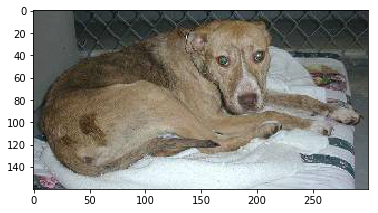

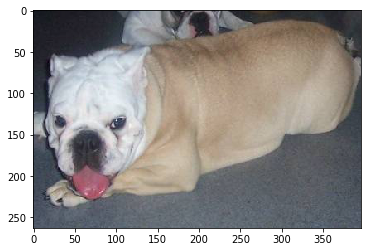

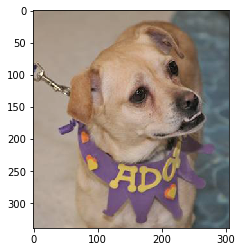

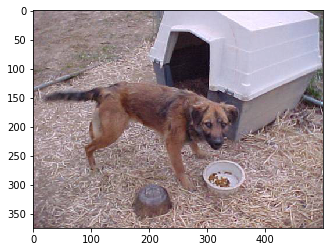

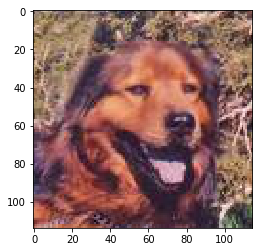

In [12]:
let images = trainList[0..<5]
for i in 0..<5 {
    plotImages(fromPath: String(images[i])!)
}

# Model Creation

## Define the model

The model consists of four convolution blocks with a max pool layer in each of them. Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax`. 

In [0]:
// A classifier.
struct Classifier: Layer {
    typealias Input = Tensor<Float>
    typealias Output = Tensor<Float>

    var conv1a = Conv2D<Float>(filterShape: (3, 3, 3, 32), activation: relu)
    var pool1 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    
    var conv1b = Conv2D<Float>(filterShape: (3, 3, 32, 64), activation: relu)
    var pool2 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    
    var conv1c = Conv2D<Float>(filterShape: (3, 3, 64, 128), activation: relu)
    var pool3 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    
    var conv1d = Conv2D<Float>(filterShape: (3, 3, 128, 128), activation: relu)
    var pool4 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    
    var flatten = Flatten<Float>()
    var layer1a = Dense<Float>(inputSize: 6272, outputSize: 512, activation: relu)
    var layer1b = Dense<Float>(inputSize: 512, outputSize: 2, activation: softmax)

    @differentiable
    public func callAsFunction(_ input: Input) -> Output {
        var convolved1 = input.sequenced(through: conv1a, pool1)
        var convolved2 = convolved1.sequenced(through: conv1b, pool2)
        var convolved3 = convolved2.sequenced(through: conv1c, pool3)
        var convolved4 = convolved3.sequenced(through: conv1d, pool4)
        return convolved4.sequenced(through: flatten, layer1a, layer1b)
    }
}

### Compile the model

As usual, we will use the `adam` optimizer. Since we are output a softmax categorization, we'll use `softmaxCrossEntropy` as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [14]:
let tensor = Tensor<Float>(zeros:[100, 150, 150, 3])
var classifier = Classifier()
var optimizer = Adam(for: classifier, learningRate: 0.001)
classifier(tensor).shape

▿ [100, 2]
  ▿ dimensions : 2 elements
    - 0 : 100
    - 1 : 2


In [0]:
let epochCount = 100
let batchSize = 100

// Extract a batch of size batchSize.
func minibatch<Scalar>(in x: Tensor<Scalar>, at index: Int) -> Tensor<Scalar> {
    let start = index * batchSize
    return x[start..<start+batchSize]
}

In [0]:
var trainingAccuracy: [Float] = []
var validationAccuracy: [Float] = []
var trainingLoss: [Float] = []
var validationLoss: [Float] = []
var epochsRange: [Int] = []

### Train the model

It's time we train our network. 

In [17]:
print("Beginning training...")

struct Statistics {
    var correctGuessCount: Int = 0
    var totalGuessCount: Int = 0
    var totalLoss: Float = 0
}

// The training loop.
for epoch in 1...epochCount {
    epochsRange.append(epoch)
    var trainStats = Statistics()
    var testStats = Statistics()
    Context.local.learningPhase = .training
    for i in 0..<Int(trainList.count) / batchSize {
        let x = minibatch(in: trainImageTensors, at: i)
        let y = minibatch(in: trainLabelTensors, at: i)
        // Compute the gradient with respect to the model.
        let 𝛁model = classifier.gradient { classifier -> Tensor<Float> in
            let ŷ = classifier(x)
            let correctPredictions = ŷ.argmax(squeezingAxis: 1) .== y
            trainStats.correctGuessCount += Int(
              Tensor<Int32>(correctPredictions).sum().scalarized())
            trainStats.totalGuessCount += batchSize
            let loss = softmaxCrossEntropy(logits: ŷ, labels: y)
            trainStats.totalLoss += loss.scalarized()
            return loss
        }
        // Update the model's differentiable variables along the gradient vector.
        optimizer.update(&classifier.allDifferentiableVariables, along: 𝛁model)
    }

    Context.local.learningPhase = .inference
    for i in 0..<Int(testList.count) / batchSize {
        let x = minibatch(in: testImageTensors, at: i)
        let y = minibatch(in: testLabelTensors, at: i)
        // Compute loss on test set
        let ŷ = classifier(x)
        let correctPredictions = ŷ.argmax(squeezingAxis: 1) .== y
        testStats.correctGuessCount += Int(Tensor<Int32>(correctPredictions).sum().scalarized())
        testStats.totalGuessCount += batchSize
        let loss = softmaxCrossEntropy(logits: ŷ, labels: y)
        testStats.totalLoss += loss.scalarized()
    }
    
    let trainAccuracy = Float(trainStats.correctGuessCount) / Float(trainStats.totalGuessCount)
    let testAccuracy = Float(testStats.correctGuessCount) / Float(testStats.totalGuessCount)
    
    trainingAccuracy.append(trainAccuracy)
    validationAccuracy.append(testAccuracy)
    trainingLoss.append(trainStats.totalLoss)
    validationLoss.append(testStats.totalLoss)
    
    print("""
          [Epoch \(epoch)] \
          Training Loss: \(trainStats.totalLoss), \
          Training Accuracy: \(trainStats.correctGuessCount)/\(trainStats.totalGuessCount) \ 
          (\(trainAccuracy)), \
          Test Loss: \(testStats.totalLoss), \
          Test Accuracy: \(testStats.correctGuessCount)/\(testStats.totalGuessCount) \
          (\(testAccuracy))
          """)
}

Beginning training...
[Epoch 1] Training Loss: 14.028344, Training Accuracy: 956/2000 (0.478), Test Loss: 6.933517, Test Accuracy: 500/1000 (0.5)
[Epoch 2] Training Loss: 13.88098, Training Accuracy: 988/2000 (0.494), Test Loss: 6.931262, Test Accuracy: 500/1000 (0.5)
[Epoch 3] Training Loss: 13.869087, Training Accuracy: 1005/2000 (0.5025), Test Loss: 6.9294, Test Accuracy: 527/1000 (0.527)
[Epoch 4] Training Loss: 13.874498, Training Accuracy: 988/2000 (0.494), Test Loss: 6.9295063, Test Accuracy: 500/1000 (0.5)
[Epoch 5] Training Loss: 13.881882, Training Accuracy: 1020/2000 (0.51), Test Loss: 6.9232965, Test Accuracy: 522/1000 (0.522)
[Epoch 6] Training Loss: 13.871335, Training Accuracy: 997/2000 (0.4985), Test Loss: 6.9309387, Test Accuracy: 500/1000 (0.5)
[Epoch 7] Training Loss: 13.884668, Training Accuracy: 1003/2000 (0.5015), Test Loss: 6.930708, Test Accuracy: 502/1000 (0.502)
[Epoch 8] Training Loss: 13.861109, Training Accuracy: 1044/2000 (0.522), Test Loss: 6.9259143, Tes

### Visualizing results of the training

We'll now visualize the results we get after training our network.

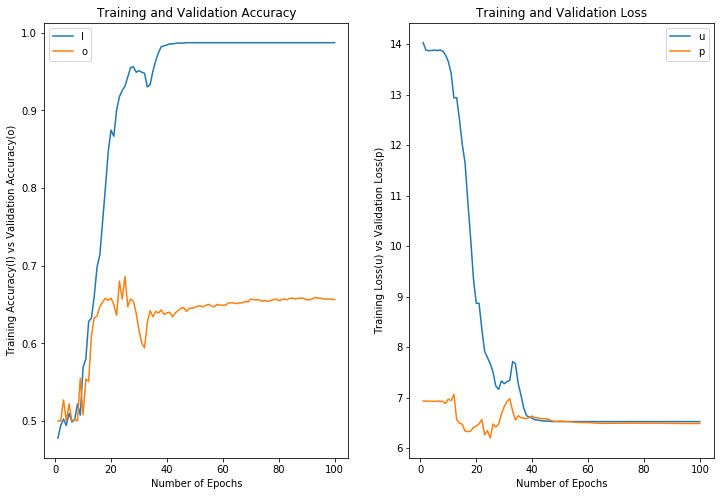

None


In [18]:
plt.figure(figsize: [12, 8])
plt.subplot(1, 2, 1)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Accuracy(l) vs Validation Accuracy(o)")
plt.plot(epochsRange, trainingAccuracy)
plt.plot(epochsRange, validationAccuracy)
var loc = "lower right"
plt.legend(loc)
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss(u) vs Validation Loss(p)")
plt.plot(epochsRange, trainingLoss)
plt.plot(epochsRange, validationLoss)
loc = "upper right"
plt.legend(loc)
plt.title("Training and Validation Loss")
plt.show()

As we can see from the plots, training accuracy and validation accuracy are off by large margin and our model has achieved only around **75%** accuracy on the validation set (depending on the number of epochs you trained for).

This is a clear indication of overfitting. Once the training and validation curves start to diverge, our model has started to memorize the training data an is unable to perform well on the validation data.